# Store Item Demand Forecasting Challenge

This notebook implements a solution for the 'Item Demand Forecasting Challange' using FBprophet and simple linear regression. With this approach we archieved a MAE of 6.7 on a six month validation set.

"This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

This is a great competition to explore different models and improve your skills in forecasting."

From: kaggle.com

The files can be found at: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview


Author: Caio Nunes


## Importing Packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import fbprophet
from sklearn.metrics import mean_absolute_error


## Loading and checking the data

In [3]:
folder = ''

val_set_bound = '2017-06-01'

train_x = pd.read_csv(folder + 'train.csv')
train_x['date'] = pd.to_datetime(train_x['date'])

train_x['ds'] = train_x['date']
train_x['y'] = train_x['sales']

train_x = train_x.set_index('date')

val_x = train_x.loc[val_set_bound:]
train_x = train_x.loc[:val_set_bound]

test_x = pd.read_csv(folder + 'test.csv')
test_x.drop(['id'], axis = 1, inplace = True)
test_x['date'] = pd.to_datetime(test_x['date'])
test_x = test_x.set_index('date')

submission = pd.read_csv(folder + 'sample_submission.csv')

train_x.tail()

store  item  sales         ds    y
date                                          
2017-05-28     10    50    110 2017-05-28  110
2017-05-29     10    50     69 2017-05-29   69
2017-05-30     10    50     91 2017-05-30   91
2017-05-31     10    50    102 2017-05-31  102
2017-06-01     10    50    117 2017-06-01  117

## Data visualization


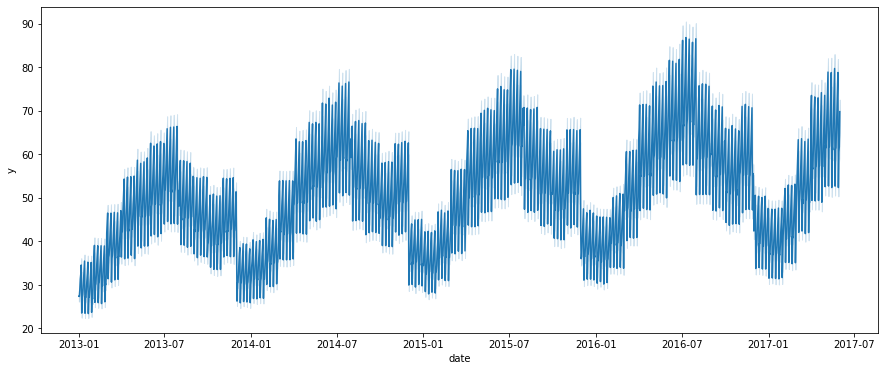

In [4]:
plt.figure(figsize=(15,6))

sns.lineplot(x = train_x.index, y = train_x.y)

This plot tell us some good news: we have a clear seasonal behavior and little meaning increase, which is really nice for time series forecast.

But, the hard thing about this is series is that it is not a single serie! We have 500 different series packed together (one for each item/store combination pair).

## Making it simple

For now let's just forecast the daily mean sales count of all items/stores. 

/home/caio/anaconda3/envs/ML/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



2.848858898141876


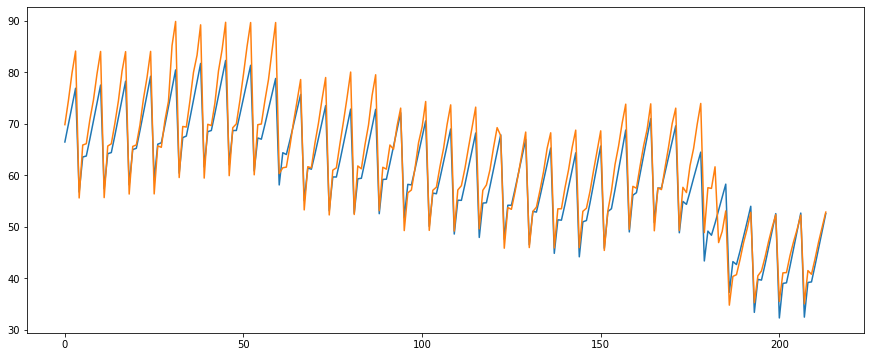

In [5]:
big_train_x = train_x.groupby(['date']).agg({'y': 'mean'})
big_train_x['ds'] = big_train_x.index

big_val_x = val_x.groupby(['date']).agg({'y': 'mean'})
big_val_x['ds'] = big_val_x.index


Prophet = fbprophet.Prophet(daily_seasonality=True)
Prophet.fit(big_train_x)
prophet_forecast = Prophet.predict(big_val_x)
prophet_forecast = prophet_forecast.set_index('ds')
plt.figure(figsize=(15,6))

plt.plot(prophet_forecast['yhat'].values)
plt.plot(big_val_x['y'].values)

print(mean_absolute_error(prophet_forecast['yhat'].values, big_val_x['y'].values))

And it turn out that Prophet made a incredible job forecasting the avarage sales series. But we don't need this series, we actually need the 500 different series based on the [item, store] combination. Altough it is possible to forecast all the 500 series, it would be very time expensive and won't teach us anything.

### Looking at the sales variation per item and store

Now we are going to plot the 50 different series, one for each item and the 10 different series, one for each store.

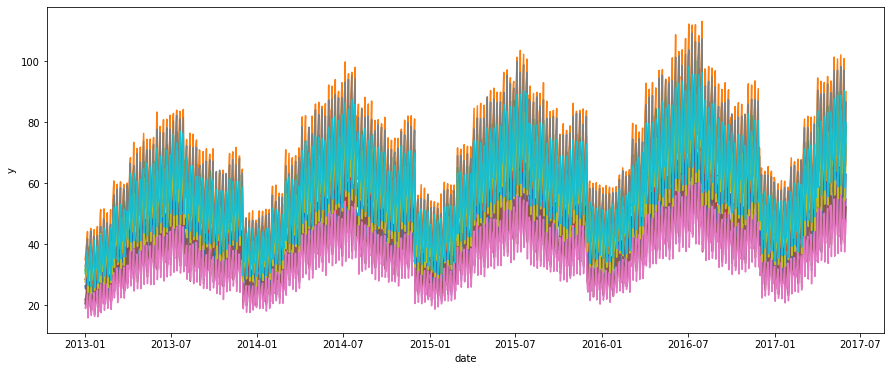

In [6]:
big_train_x = train_x.groupby(['date']).agg({'y': 'mean'})

store_train_x = train_x.groupby(['date', 'store']).agg({'y': 'mean'})

sales_by_store =  []

plt.figure(figsize=(15,6))

for i in range(len(store_train_x.index.levels[1].unique())):
    sales_by_store.append(store_train_x[store_train_x.index.get_level_values('store') == i+1])
    sns.lineplot(x = sales_by_store[i].index.get_level_values('date'), y = sales_by_store[i].y)



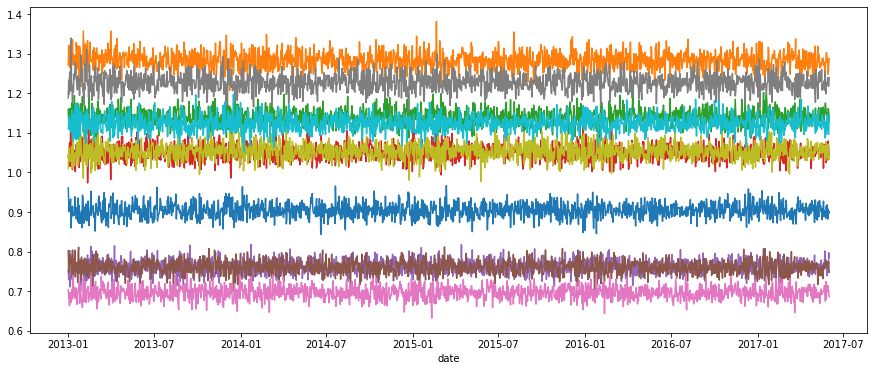

In [7]:
relative_sales_by_store = []

plt.figure(figsize=(15,6))

for i in range(len(sales_by_store)):
    relative_sales_by_store.append(sales_by_store[i].y.values/big_train_x.y.values)
    sns.lineplot(x = big_train_x.index, y = relative_sales_by_store[i])

With this beautiful plots we can see that:

1 - The stores do have different relative sales ratio, and as expected some of them sold more than the avarage and some of them sold less; 

2 - The relative sales ratio is pretty much stationary, then with some generalization we can say that this ratios are constats trough the time;

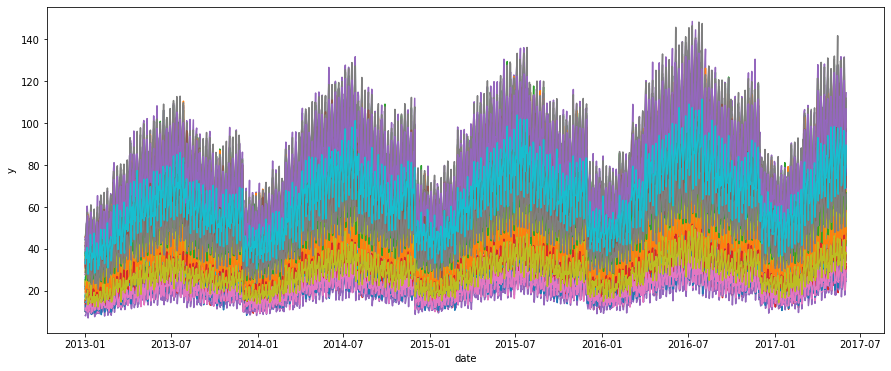

In [8]:
item_train_x = train_x.groupby(['date', 'item']).agg({'y': 'mean'})

sales_by_item =  []

plt.figure(figsize=(15,6))

for i in range(len(item_train_x.index.levels[1].unique())):
    sales_by_item.append(item_train_x[item_train_x.index.get_level_values('item') == i+1])
    sns.lineplot(x = sales_by_item[i].index.get_level_values('date'), y = sales_by_item[i].y)

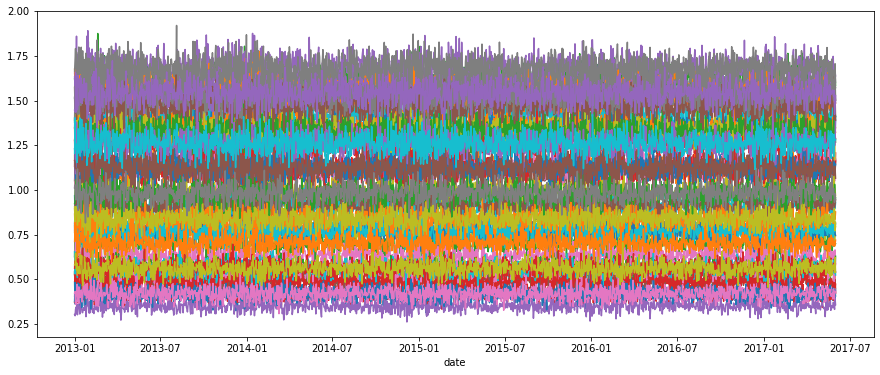

In [9]:
relative_sales_by_item = []

plt.figure(figsize=(15,6))

for i in range(len(sales_by_item)):
    relative_sales_by_item.append(sales_by_item[i].y.values/big_train_x.y.values)
    sns.lineplot(x = big_train_x.index, y = relative_sales_by_item[i])
    

The same said about the stores ratios applies to the items.

## Our model!

Now we are going to build a model that uses (1) the global forecast data, (2) the item/sales ratio and (3) the store/sales ratio.

Our final prediction will be: (prophet forecast) * (item ratio) * (store ratio)


### Making predictions

In [10]:
item_ratio = []
for item in relative_sales_by_item:
    item_ratio.append(item.mean())
    
store_ratio = []
for store in relative_sales_by_store:
    store_ratio.append(store.mean())
    
prediction = []

for i in val_x.index.unique():
    if not i.date() in prophet_forecast.index.unique():
        print(i)

for i in range(len(val_x)):
    entry = val_x.iloc[i]
    prediction.append(item_ratio[entry['item'] - 1] * store_ratio[entry['store'] - 1] \
                      *prophet_forecast.loc[entry['ds']]['yhat'])

print(mean_absolute_error(prediction, val_x['y'].values))

6.732738745351328


As you can see with this simples forecast method we scored an amazing 6.73 MSE for our 6 month validation set.

## But why?

In our model we assumed that the sales count depends on:
1 - The time (day of the week, month, year);
2 - The store that is selling the item;
3 - The item itself;

And it happens that FBprophet is very good at forecasting time dependent series, so we dont had to waste a lot of time trying to model something to predict the time component.
Also, the store/sales and item/sales ratio are almost time constant in our data, which makes our job much softer.

## Extra: Creating our prediction module

Our prediction function will simply take the train and test set and then return the predicted values.

In [11]:
def sales_prediction(train,test):
    #Training the prophet forecast model
    test['ds'] = test.index
    train_by_date = train.groupby(['date']).agg({'y': 'mean'})
    train_by_date['ds'] = train_by_date.index

    test_by_date = test.groupby(['date']).agg({'store': 'sum'})
    test_by_date['ds'] = test_by_date.index
    
    Prophet = fbprophet.Prophet(daily_seasonality=True)
    Prophet.fit(train_by_date)
    prophet_forecast = Prophet.predict(test_by_date)
    prophet_forecast = prophet_forecast.set_index('ds')
    
    #Getting the item/sales ratio
    
    train_by_item = train.groupby(['date', 'item']).agg({'y': 'mean'})

    sales_by_item =  []

    for i in range(len(train_by_item.index.levels[1].unique())):
        sales_by_item.append(train_by_item[train_by_item.index.get_level_values('item') == i+1])
    
    item_sales_ratio = []

    for i in range(len(sales_by_item)):
        relative_sales_by_item = sales_by_item[i].y.values/train_by_date.y.values
        item_sales_ratio.append(relative_sales_by_item.mean())
    
    #Now, getting the store/sales ratio
    
    train_by_store = train.groupby(['date', 'store']).agg({'y': 'mean'})

    sales_by_store =  []

    for i in range(len(train_by_store.index.levels[1].unique())):
        sales_by_store.append(train_by_store[train_by_store.index.get_level_values('store') == i+1])
    
    store_sales_ratio = []

    for i in range(len(sales_by_store)):
        relative_sales_by_store = sales_by_store[i].y.values/train_by_date.y.values
        store_sales_ratio.append(relative_sales_by_store.mean())
    
    #Making the prediction
    
    prediction = []
    for i in range(len(test)):
        entry = test.iloc[i]
        prediction.append(item_sales_ratio[entry['item'] - 1] * store_sales_ratio[entry['store'] - 1] \
                          *prophet_forecast.loc[entry['ds']]['yhat'])

    
    return prediction

train_x = train_x.append(val_x)
yhat = sales_prediction(train_x, test_x)
    

/home/caio/anaconda3/envs/ML/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



### Creating the Kaggle Submission File

In [12]:
submission.sales = yhat
submission.head()
submission.to_csv('submission.csv', index= False)